In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##### Importing Dataset as Pandas Dataframe

In [2]:
df = pd.read_csv('vehicle.csv')
df.head()

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
0,95,48.0,83.0,178.0,72.0,10,162.0,42.0,20.0,159,176.0,379.0,184.0,70.0,6.0,16.0,187.0,197,van
1,91,41.0,84.0,141.0,57.0,9,149.0,45.0,19.0,143,170.0,330.0,158.0,72.0,9.0,14.0,189.0,199,van
2,104,50.0,106.0,209.0,66.0,10,207.0,32.0,23.0,158,223.0,635.0,220.0,73.0,14.0,9.0,188.0,196,car
3,93,41.0,82.0,159.0,63.0,9,144.0,46.0,19.0,143,160.0,309.0,127.0,63.0,6.0,10.0,199.0,207,van
4,85,44.0,70.0,205.0,103.0,52,149.0,45.0,19.0,144,241.0,325.0,188.0,127.0,9.0,11.0,180.0,183,bus


##### Shape of Dataset
* No of datapoints - 846
* No of features - 19

In [3]:
df.shape

(846, 19)

* All the independent features are numeric datatype
* Also there is some null values for few attributes

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   compactness                  846 non-null    int64  
 1   circularity                  841 non-null    float64
 2   distance_circularity         842 non-null    float64
 3   radius_ratio                 840 non-null    float64
 4   pr.axis_aspect_ratio         844 non-null    float64
 5   max.length_aspect_ratio      846 non-null    int64  
 6   scatter_ratio                845 non-null    float64
 7   elongatedness                845 non-null    float64
 8   pr.axis_rectangularity       843 non-null    float64
 9   max.length_rectangularity    846 non-null    int64  
 10  scaled_variance              843 non-null    float64
 11  scaled_variance.1            844 non-null    float64
 12  scaled_radius_of_gyration    844 non-null    float64
 13  scaled_radius_of_gyr

* On checking there is few countable no of missing values in some columns.
* We will analyse it further to decide how to treat these missing value

In [5]:
df.isna().sum()

compactness                    0
circularity                    5
distance_circularity           4
radius_ratio                   6
pr.axis_aspect_ratio           2
max.length_aspect_ratio        0
scatter_ratio                  1
elongatedness                  1
pr.axis_rectangularity         3
max.length_rectangularity      0
scaled_variance                3
scaled_variance.1              2
scaled_radius_of_gyration      2
scaled_radius_of_gyration.1    4
skewness_about                 6
skewness_about.1               1
skewness_about.2               1
hollows_ratio                  0
class                          0
dtype: int64

* From this 5 point summary, we can see all the featurea have different range of values.
* So we have to scale it to make sure that our model gives equal importance to all the features.

In [6]:
col = df.columns[df.isnull().any()]
df.describe().T

,count,mean,std,min,25%,50%,75%,max
compactness,846.0,93.678487,8.234474,73.0,87.00,93.0,100.0,119.0
circularity,841.0,44.828775,6.152172,33.0,40.00,44.0,49.0,59.0
distance_circularity,842.0,82.110451,15.778292,40.0,70.00,80.0,98.0,112.0
radius_ratio,840.0,168.888095,33.520198,104.0,141.00,167.0,195.0,333.0
pr.axis_aspect_ratio,844.0,61.678910,7.891463,47.0,57.00,61.0,65.0,138.0
max.length_aspect_ratio,846.0,8.567376,4.601217,2.0,7.00,8.0,10.0,55.0
scatter_ratio,845.0,168.901775,33.214848,112.0,147.00,157.0,198.0,265.0
elongatedness,845.0,40.933728,7.816186,26.0,33.00,43.0,46.0,61.0
pr.axis_rectangularity,843.0,20.582444,2.592933,17.0,19.00,20.0,23.0,29.0
max.length_rectangularity,846.0,147.998818,14.515652,118.0,137.00,146.0,159.0,188.0


* Distribution of each class is not even but it is fairly enough to proceed with the model. 

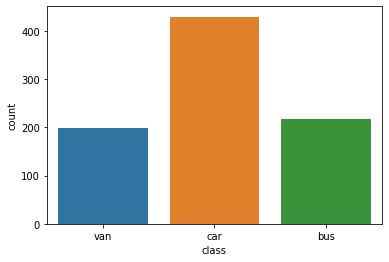

In [7]:
sns.countplot(df['class'])

##### Correlation
* From the heatmap we can see that there are many multicorrelation features.
* Highly correlated features provide same information for the model.
* So we can drop the highly correlated features

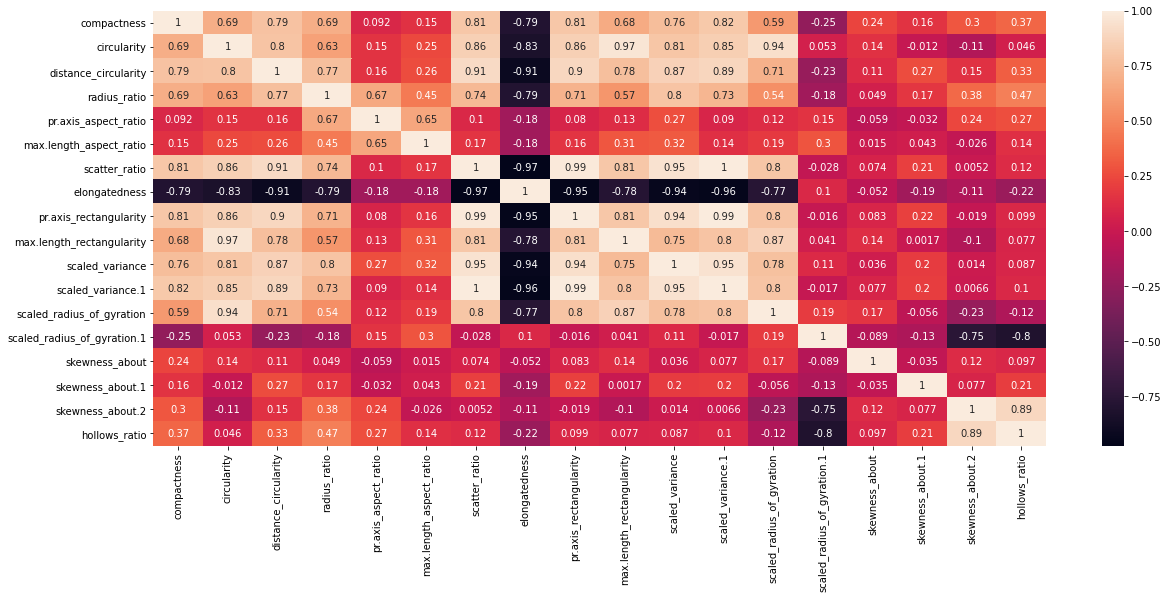

In [8]:
fig, ax = plt.subplots(figsize = [20, 8])
corr = df.corr() #Finding correlation of all the features
sns.heatmap(corr, annot = True)

##### Multicorrelated features
* We filtered all highly correlated features.
* We can see that features (compactness, circularity, distance_circularity,elongatedness, pr.axis_rectangularity, max.length_rectangularity,scaled_variance, scaled_variance.1, scaled_radius_of_gyration) are highly correlated to scatter_ratio. So scatter_ratio alone will represent all these features.
* Similarly hollows_ratio alone represent the features scaled_radius_of_gyration.1, skewness_about.2 

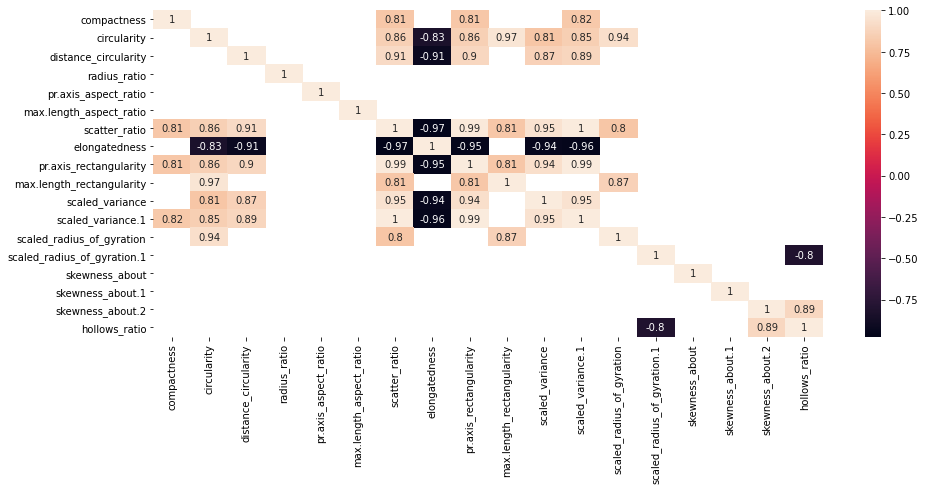

In [9]:
fig, ax = plt.subplots(figsize = [15, 6])
corr_pos = corr.abs() # Making all the values postive
mask = corr_pos < 0.8 #Mask the correlation less than 0.8
sns.heatmap(corr, annot = True, mask = mask)

* We can use only the below mentioned features for our model without PCA

In [10]:
selected_columns = [ 'radius_ratio','pr.axis_aspect_ratio', 'max.length_aspect_ratio', 
                    'scatter_ratio','skewness_about', 'skewness_about.1',
                    'hollows_ratio']

##### Test to impute the values with median
* The no of missing rows is very few compared to dataset size.
* Here we are replacing the missing value with median and checking whether any huge difference in correlation between the features before and after imputing.
* We found that there is not much variation in correlation between the features, so the dataset is not much biased by this impute. 

In [11]:
i_median = SimpleImputer(strategy = 'median')
df_median = df.copy() #Making a copy to impute the dataset
df_median[col] = i_median.fit_transform(df[col]) # Imputing with median for missing values
corr_median = df_median.corr() # finding the correlation for imputed dataframe
diff = corr - corr_median
print(diff.max()) #printing only the maximum correlation of each features

compactness                    0.004898
circularity                    0.014917
distance_circularity           0.004860
radius_ratio                   0.007162
pr.axis_aspect_ratio           0.001916
max.length_aspect_ratio        0.000492
scatter_ratio                  0.010327
elongatedness                  0.000357
pr.axis_rectangularity         0.013203
max.length_rectangularity      0.004411
scaled_variance                0.010485
scaled_variance.1              0.014917
scaled_radius_of_gyration      0.010134
scaled_radius_of_gyration.1    0.001134
skewness_about                 0.000770
skewness_about.1               0.001964
skewness_about.2               0.001288
hollows_ratio                  0.001288
dtype: float64


##### Distribution of selected features

* We have 3 classes in target column, so the plot represents the distribution of 3 classes.
* It is the reason that we can see multiple peaks in most of the features.
* Mean and median are almost equal in all distribution but having outlier in some plots is pulling the mean towards slightly right side. 

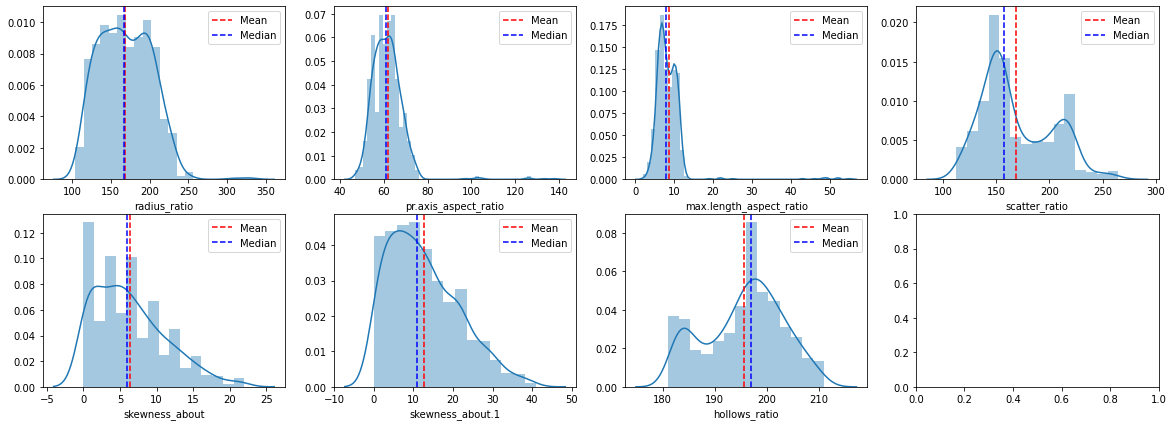

In [12]:
fix, ax = plt.subplots(nrows = 2, ncols = 4, figsize = [20, 7])

for col, axes in zip(selected_columns, ax.flatten()):
  sns.distplot(df[col], ax = axes)
  mean = df[col].mean()
  median = df[col].median()
  axes.axvline(mean, color = 'r', linestyle = '--') # Vertical line along axis to indicate the mean
  axes.axvline(median, color = 'b', linestyle = '--') # Vertical line to indicate the median
  axes.legend({'Mean': mean, 'Median': median})

##### Box Plot
* Other than hollow ratio and scatter ratio, we could see some outliers in all other features.
* Since most of the outliers are nearer to the 1.5*IQR bin, we can replace the outliers with lower and upper bin,
* Not having outliers in hollow ratio and scatter ratio is good as treating outliers on it may change the distribution as it is representing many other features. 

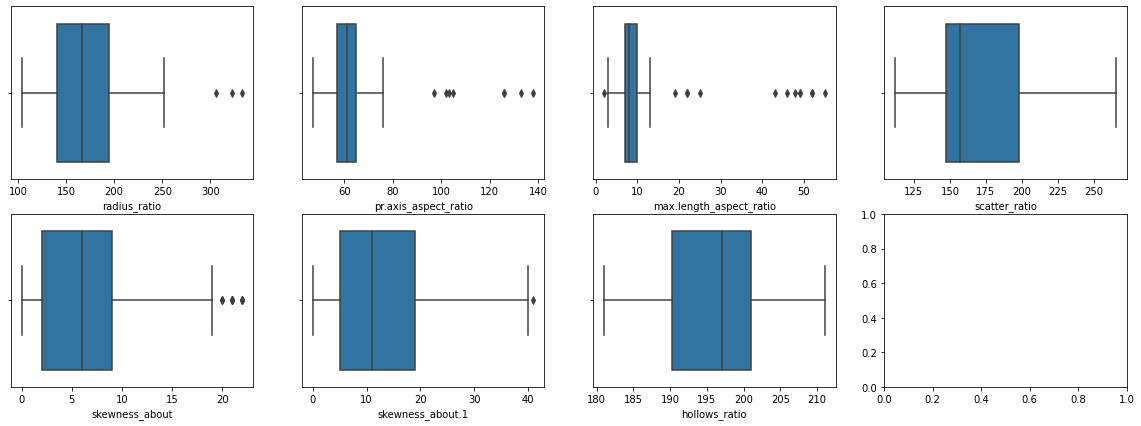

In [13]:
fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize = [20, 7])

for col, axes in zip(selected_columns, ax.flatten()):
  sns.boxplot(df[col], ax = axes)

##### Independent features vs Target feature
* This plot helps us to find the importance of each feature individually in predicting the target.
* The feature which has higher variation in box amoung the classes will contribute more in prediction.
* We could see that Scatter ratio and hollows ration will be good predictor.

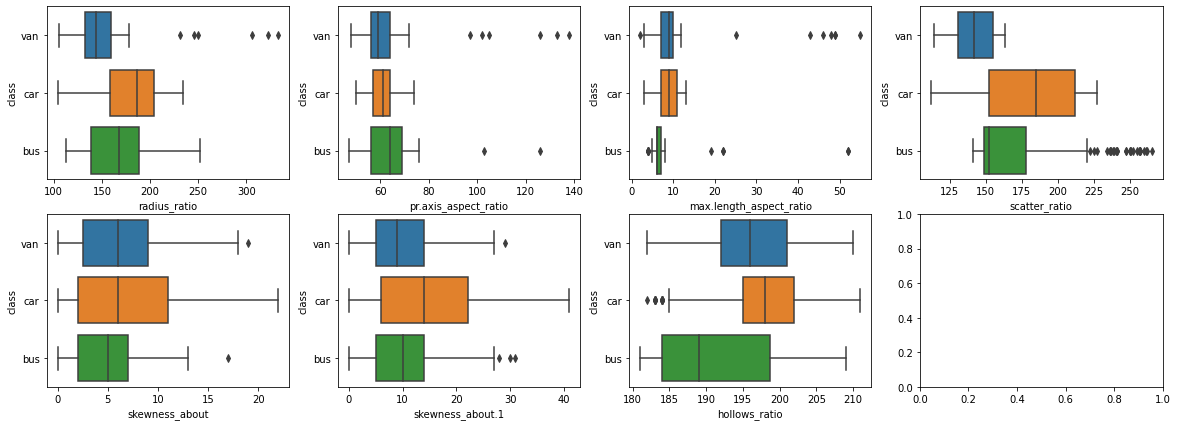

In [14]:
fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize = [20, 7])

for col, axes in zip(selected_columns, ax.flatten()):
  sns.boxplot(x = col, y = 'class', data = df, ax = axes)

#### Pipeline

* We are using Pipeline feature available in Scikit Learn to build our model.
* Pipelines helps to bulid a better readable organized model.
* It helps to process the train, test dataset seperately which refrains the model from data leakage.

---
#### Planned Steps:-

1. Preprocessing
>* Selection only these features and removing all highly correlated features. 
>* Selected Features: ( radius_ratio, pr.axis_aspect_ratio, max.length_aspect_ratio scatter_ratio, skewness_about, skewness_about.1,hollows_ratio)
>* Imputing missing values with median
>* Replacing the outliers with 1.5*IQR in both upper and lower limit


2. Scaling
>* Scaling all the input features.

4. ML Model
>* Fitting the data to SVM Model.

In [15]:
def outlier_removal(ar): # Function to replace outliers with 1.5*IQR in both lower and higher side
  for i in range(7):
    p = np.percentile(ar[:, i], [25, 75])
    iqr = p[1] - p[0]
    q1 = p[0]- 1.5*iqr
    q3 = p[1]+ 1.5*iqr
    ar[:, i][ar[:, i]<q1] = q1
    ar[:, i][ar[:, i]>q3] = q3
  return ar

In [16]:
seed = 3
pipeline = Pipeline(
    [('impute', SimpleImputer(strategy = 'median')),
    ('outlier', FunctionTransformer(outlier_removal)),
    ('scale', StandardScaler()),
    ('model', SVC(random_state = seed))
       ])

In [17]:
x = df[selected_columns]
y = df['class']
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify = y, test_size = 0.3, random_state = seed)

In [18]:
performance = pd.DataFrame(columns = ['Type', 'Train Accuracy', 'Test Accuracy', 'Mean cross validation score', 'Deviation'])
normal_model = pipeline.fit(x_train, y_train)
cv = StratifiedKFold()
normal_score = cross_val_score( normal_model, X=x, y=y, scoring = 'accuracy', n_jobs = -1, cv = cv)
performance = performance.append({'Type': 'Model without PCA and tuning',
                                 'Train Accuracy': normal_model.score(x_train, y_train)*100,
                                 'Test Accuracy': normal_model.score(x_test, y_test)*100,
                                 'Mean cross validation score': normal_score.mean()*100,
                                 'Deviation': 2*100*normal_score.std()}, ignore_index = True)

print("--------------------------Model without PCA and tuning-----------------------------------\n")
print("Train accuracy : {:2.2f}%".format(normal_model.score(x_train, y_train)*100))
print("Test accuracy : {:2.2f}%".format(normal_model.score(x_test, y_test)*100))
print("Cross validation mean score: {:2.2f}% with deviation (+/-{:2.2f}%)" .format(normal_score.mean()*100, 2*100*normal_score.std()))

--------------------------Model without PCA and tuning-----------------------------------

Train accuracy : 95.27%
Test accuracy : 92.52%
Cross validation mean score: 93.26% with deviation (+/-2.65%)


In [19]:
params_svm = {
    'model__C': [i for i in range(1, 15, 1)],
    #'model__kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
    'model__kernel' : ['rbf'], # Checked with all kernaels but RBF performed well, so using RBF in all the upcoming iterations
    'model__gamma' : np.logspace(-5, -1, 30)
            }


model_tuning = GridSearchCV(pipeline, params_svm, scoring = 'accuracy')

In [20]:
model_tuning.fit(x_train, y_train)
tuned_score = cross_val_score( model_tuning.best_estimator_, X=x, y=y, scoring = 'accuracy', n_jobs = -1, cv = cv)
performance = performance.append({'Type': 'Model without PCA and with tuning',
                                 'Train Accuracy': model_tuning.score(x_train, y_train)*100,
                                 'Test Accuracy': model_tuning.score(x_test, y_test)*100,
                                 'Mean cross validation score': tuned_score.mean()*100,
                                 'Deviation': 2*100*tuned_score.std()}, ignore_index = True)
print("--------------------------Model without PCA and with tuning-----------------------------------\n")
print("Train accuracy : {:2.2f}%".format(model_tuning.score(x_train, y_train)*100))
print("Test accuracy : {:2.2f}%".format(model_tuning.score(x_test, y_test)*100))
print("Cross validation mean score: {:2.2f}% with deviation (+/-{:2.2f}%)" .format(tuned_score.mean()*100, 2*100*tuned_score.std()))

--------------------------Model without PCA and with tuning-----------------------------------

Train accuracy : 96.96%
Test accuracy : 93.70%
Cross validation mean score: 94.92% with deviation (+/-2.42%)


##### Pipeline with PCA

* PCA model re-arrange the feature based on the amount of variation explained. 
* Also it removes the correlation between the features making it independent to each other which is ideally expected for all machine learning algorithms

#### Planned Steps:-

1. Preprocessing
>* Giving All the features as input as we using PCA for feature selection. 
>* Imputing missing values with median
>* Replacing the outliers with 1.5*IQR in both upper and lower limit


2. Scaling
>* Scaling all the input features.

3. Feature selection
>* Using PCA for feature selection.

4. ML Model
>* Fitting the data to SVM Model.

In [21]:
def outlier_removal_pca(ar):
  for i in range(18):
    p = np.percentile(ar[:, i], [25, 75])
    iqr = p[1] - p[0]
    q1 = p[0]- 1.5*iqr
    q3 = p[1]+ 1.5*iqr
    ar[:, i][ar[:, i]<q1] = q1
    ar[:, i][ar[:, i]>q3] = q3
  return ar

In [22]:
from sklearn.decomposition import PCA
pipeline_pca = Pipeline(
    [('impute', SimpleImputer(strategy = 'median')),
    ('outlier', FunctionTransformer(outlier_removal_pca)),
    ('scale', StandardScaler()),
    ('pca', PCA(random_state = seed)),
    ('model', SVC( random_state = seed))
       ])

In [23]:
x_pca = df.drop('class', axis = 1)
y_pca = df['class']
x_train_pca, x_test_pca, y_train_pca, y_test_pca = train_test_split(x_pca, y_pca, stratify = y_pca, test_size = 0.3, random_state = seed)

In [24]:
pipeline_pca.fit(x_train_pca, y_train_pca)
normal_score_pca = cross_val_score( pipeline_pca, X=x_pca, y=y_pca, scoring = 'accuracy', n_jobs = -1, cv = cv)
performance = performance.append({'Type': 'Model with PCA and without tuning',
                                 'Train Accuracy': pipeline_pca.score(x_train_pca, y_train_pca)*100,
                                 'Test Accuracy': pipeline_pca.score(x_test_pca, y_test_pca)*100,
                                 'Mean cross validation score': normal_score_pca.mean()*100,
                                 'Deviation': 2*100*normal_score_pca.std()}, ignore_index = True)
print("--------------------------Model with PCA and without tuning-----------------------------------\n")
print("Train accuracy : {:2.2f}%".format(pipeline_pca.score(x_train_pca, y_train_pca)*100))
print("Test accuracy : {:2.2f}%".format(pipeline_pca.score(x_test_pca, y_test_pca)*100))
print("Cross validation mean score: {:2.2f}% with deviation (+/-{:2.2f}%)" .format(normal_score_pca.mean()*100, 2*100*normal_score_pca.std()))

--------------------------Model with PCA and without tuning-----------------------------------

Train accuracy : 97.97%
Test accuracy : 96.46%
Cross validation mean score: 96.57% with deviation (+/-3.28%)


In [25]:
params_svm = {
    'model__C': [i for i in range(1, 15, 1)],
    #'model__kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
    'model__kernel' : ['rbf'],
    'model__gamma' : np.logspace(-5, -1, 30)
            }
model_tuning_pca = GridSearchCV(pipeline_pca, params_svm, scoring = 'accuracy')

* We could see that the PCA model with all features performed well in SVM model as the PCA made all the new features independent to each other.

In [26]:
model_tuning_pca.fit(x_train_pca, y_train_pca)
tuned_score_pca = cross_val_score( model_tuning_pca.best_estimator_, X=x_pca, y=y_pca, scoring = 'accuracy', n_jobs = -1, cv = cv)
performance = performance.append({'Type': 'Model with PCA and tuning',
                                 'Train Accuracy': model_tuning_pca.score(x_train_pca, y_train_pca)*100,
                                 'Test Accuracy': model_tuning_pca.score(x_test_pca, y_test_pca)*100,
                                 'Mean cross validation score': tuned_score_pca.mean()*100,
                                 'Deviation': 2*100*tuned_score_pca.std()}, ignore_index = True)
print("--------------------------Model with PCA and tuning-----------------------------------\n")
print("Train accuracy : {:2.2f}%".format(model_tuning_pca.score(x_train_pca, y_train_pca)*100))
print("Test accuracy : {:2.2f}%".format(model_tuning_pca.score(x_test_pca, y_test_pca)*100))
print("Cross validation mean score: {:2.2f}% with deviation (+/-{:2.2f}%)" .format(tuned_score_pca.mean()*100, 2*100*tuned_score_pca.std()))

--------------------------Model with PCA and tuning-----------------------------------

Train accuracy : 99.66%
Test accuracy : 98.82%
Cross validation mean score: 98.35% with deviation (+/-1.56%)


In [27]:
model_tuning_pca.best_params_

{'model__C': 14, 'model__gamma': 0.03856620421163472, 'model__kernel': 'rbf'}

In [28]:
n_features = np.arange(2, 19)
model = pipeline_pca
pca_analysis = pd.DataFrame(columns = ['n_features', 'Explained_variation', 'Accuracy'])
for i in n_features:
  #Using the best paramters estimated by the model in hyper parameter tuning
  model.set_params(pca__n_components=  i, model__C = 14, model__gamma = 0.0386, model__kernel = 'rbf') 
  model.fit(x_train_pca, y_train_pca)
  pca_analysis = pca_analysis.append({'n_features': i,
                       'Explained_variation': sum(model.named_steps['pca'].explained_variance_ratio_)*100,
                      'Accuracy': model.score(x_test_pca, y_test_pca)*100 }, ignore_index = True)
  

##### Analysis of PCA 

* The figure shows the cumulative sum of percent of variation explained by the principle components.
* Also is shows the percentage of accuracy obtained on test data by training models with given no of principle components.
* As per our requirment we have to use the principle components which explains about 95% of variance.
* As per the data 95% variance will be captured when we train our model with 7 principle components.
* From the plot we can see that there is not much raise in accuracy from training with 6 to 7 principle components but there is huge raise in accuracy from training with 7 to 8 principle components. 
* So we will train with 8 principle components in our final model.  

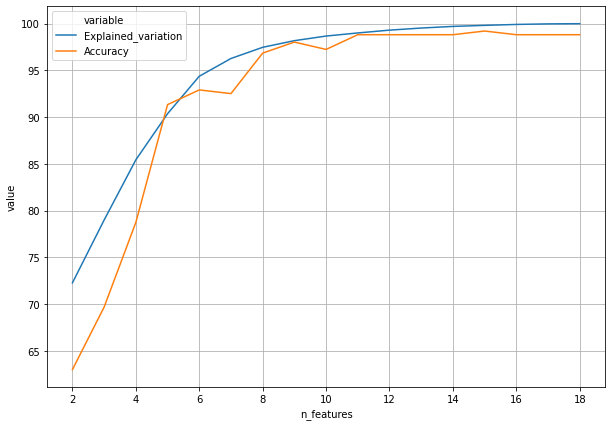

In [29]:
fig, ax = plt.subplots(figsize = [10,7])
sns.lineplot(x= 'n_features', y ='value' , hue = 'variable', data = pd.melt(pca_analysis, 'n_features'))
plt.grid()

In [30]:
model.set_params(pca__n_components=  8, model__C = 14, model__gamma = 0.0386, model__kernel = 'rbf') 
model.fit(x_train_pca, y_train_pca)
final_score_pca = cross_val_score( model, X=x_pca, y=y_pca, scoring = 'accuracy', n_jobs = -1, cv = cv)
performance = performance.append({'Type': 'Model with PCA, tuning and dimension reduction',
                                 'Train Accuracy': model.score(x_train_pca, y_train_pca)*100,
                                 'Test Accuracy': model.score(x_test_pca, y_test_pca)*100,
                                 'Mean cross validation score': final_score_pca.mean()*100,
                                 'Deviation': 2*100*final_score_pca.std()}, ignore_index = True)
print("--------------------------Model with PCA and Dimension reduction-----------------------------------\n")
print("Train accuracy : {:2.2f}%".format(model.score(x_train_pca, y_train_pca)*100))
print("Test accuracy : {:2.2f}%".format(model.score(x_test_pca, y_test_pca)*100))
print("Cross validation mean score: {:2.2f}% with deviation (+/-{:2.2f}%)" .format(final_score_pca.mean()*100, 2*100*final_score_pca.std()))

--------------------------Model with PCA and Dimension reduction-----------------------------------

Train accuracy : 97.80%
Test accuracy : 96.85%
Cross validation mean score: 95.74% with deviation (+/-2.94%)


##### Summary

1. Model with and without PCA on reduced dimensions.
>* Initially we build a model by dropping the multicorrelated features.
>* Then we build a model by dropping the features using PCA
>* Both these models are build with almost same no of  features but the model with principle components performed slightly better. 

2. Model with PCA on all dimensions and reduced dimensions.
>* We build a model with PCA and taking all the principle components.
>* Then we build a model with taking the principle components which explains about 95% of variation.
>* The 1st one performed very well as it gave the better accuracy when compared to the 2nd. 
>* The noteworthy point here is that the 1st model trained with 18 features to give 98.3% accuracy but the dimension reduced model gave around 95.7% accuracy with just 8 features.
>* So it reduced more than 50% of model complexity with a small compensation in model accuracy. 
>* So the model with PCA and reduced dimension can be considered as the final model. 

In [31]:
performance

,Type,Train Accuracy,Test Accuracy,Mean cross validation score,Deviation
0,Model without PCA and tuning,95.270270,92.519685,93.262792,2.652540
1,Model without PCA and with tuning,96.959459,93.700787,94.918900,2.419113
2,Model with PCA and without tuning,97.972973,96.456693,96.574313,3.282330
3,Model with PCA and tuning,99.662162,98.818898,98.346676,1.558475
4,"Model with PCA, tuning and dimension reduction",97.804054,96.850394,95.743822,2.941284
